This document was generated from jupyter notebook which allows direct computations. Therefore there are blocks demonstrating the computation itself fulfilled by text explaining those computation steps.

# Color analysis of XRF

In this notebook we would like to push forward macro XRF data usage for color restoration.
This have been already done in studies like:

*Anitha, A., Brasoveanu, A., Duarte, M.F., Hughes, S.M., Daubechies, I., Dik, J., Janssens, K., & Alfeld, M. (2013). Restoration of X-ray fluorescence images of hidden paintings. Signal Processing, 93, 592-604.*

*Thurrowgood, David, David Paterson, Martin D de Jonge, Robin Kirkham, Saul Thurrowgood, and Daryl L Howard, ‘A Hidden Portrait by Edgar Degas’, Scientific Reports, 6 (2016), 29594 <https://doi.org/10.1038/srep29594>*

Colors are taken from a database of elemental spectral responses and combined (combining function vary). 

In the following text we discuss:
1. What is the common information content of various modalities and how to convert them?
1. If there exist "correct" representation of color based on XRF vector
1. Are we able to reconstruct faded "color" from XRF scan?

## Suicide of Saul

**Background:** The RGB image is faded and in the left top corner "blue" buildings are invisible. Just XRF *CoK* channel contains enough contrast.

**Target:** We would like to resolve ...

1. Are we able to reconstruct color of left top part from another part of the painting?
    * Are we able to construct function converting XRF to HUE?
2. Where are the purest pigments in the painting?
    * Color count identification
    * Position of a pixels with the purest colors

### 1. Color reconstruction

#### Approach
We have tried to construct ANN which estimates HUE from given XRF vector for a pixel. The advantage of ANN is, that it is non-linear and we do not need to specify complexity of the function (it is estimated stochastically).

There were tested multiple scenarios - estimation of RGB coefficiens, estimation of HSV coordinates of color as well as estimation of just HUE. 

The HUE result is shown below. And with comparison to RGB original it is faded more than original. The question here is why?

In [6]:
%cd ..
import modalities.dir_dataset as dataset
import cv2
import matplotlib.pyplot as plt
import src.models.ig as ig
import src.data.rescale_range as rr
import numpy as np
import src.visualization.mimshow as mplot
import src.features.stats as stats
np.set_printoptions(precision=2, suppress=True)
# Load XRF data
saul, saul_metadata = dataset.load_all_images("/Users/gimli/Qsync/datasets/Suicide_Of_Saul/total_per_tif")
# Load manually registered visible image
vis = np.asarray(cv2.cvtColor(cv2.imread("/Users/gimli/Qsync/datasets/Suicide_Of_Saul/outputs/visw.png"),cv2.COLOR_BGR2HSV)).astype(np.float32)/255.0

In [41]:
######## Extrapolation from selected modalities into color HUE #########
diff, approx, model = ig.information_gain(saul[0][:,:,[1,4,6,7,9,10,11,14,18,19]], vis[:,:,0], layers=[25, 25], training_set_size=100000)

Selecting 100000 samples randomly for use by algorithm.
Adding input layer, width = 10
Adding dense layer, width = 25
Adding dense layer, width = 25
Adding dense layer, width = 1
Compiling model took 0.0974's.
Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 5s 57us/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 2/10
80000/80000 [==============================] - 4s 53us/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 3/10
80000/80000 [==============================] - 4s 53us/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/10
80000/80000 [==============================] - 4s 54us/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/10
80000/80000 [==============================] - 5s 60u

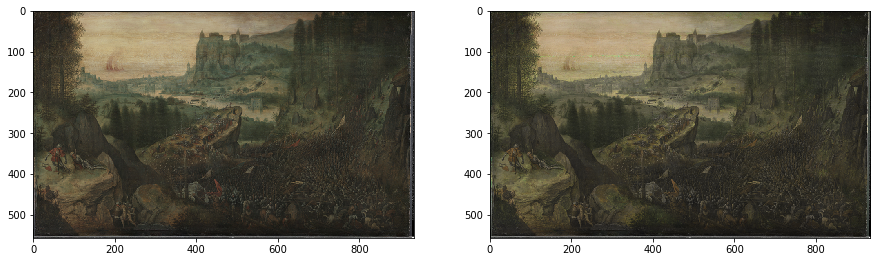

In [42]:
plt.figure(figsize=(15,5))
original = plt.subplot(121)
original.imshow(cv2.cvtColor((vis*255).astype(np.uint8), cv2.COLOR_HSV2RGB))
reconstructed = plt.subplot(122)
reconstructed.imshow(cv2.cvtColor((np.stack([approx[:,:,0], vis[:,:,1], vis[:,:,2]], axis=2)*255).astype(np.uint8), cv2.COLOR_HSV2RGB))
plt.show()

__There are hypotheses why this happen__:
1. XRF vector information content does not cover RGB information content.
2. Model is not sufficient for proper estimation
3. Data are not statistically relevant (model is too complex to be trained from the data given)

Accoriding to ANN performance we can disprove 2. and 3. because we trained just 50 parameters of ANN for which were used more than 100k pixels. This is enough for a training.

*Beleites, C. and Neugebauer, U. and Bocklitz, T. and Krafft, C. and Popp, J.: Sample size planning for classification models. Anal Chim Acta, 2013, 760, 25-33. DOI: 10.1016/j.aca.2012.11.007 accepted manuscript on arXiv: 1211.1323*

The most suitable is therefore hypothesis, that XRF and RGB are not convertible one to the other.

### 2. Simplification and behavior analysis

Before we throw the results overboard let's make the model simpler and reduce requirements for ANN outputs. Let's check how the data behaves.

#### Correlation
First of all there is relevant correlation between modalitites.

In [65]:
from termcolor import colored
corr = np.asarray(stats.correlation(np.concatenate([saul[0, :, :, :], vis], axis=2))[[1,4,6,7,9,10,11,14,18,19],25:])
modalities = ["AsK", "CaK", "CoK", "Continuum", "CuK", "FeK", "HgL", "MnK", "PbL", "PbM"]
print("XRF band", colored("HUE", color="blue"), colored("Saturation", color="green"), colored("Value", color="red"))
for i in range(len(modalities)):
    print(modalities[i], colored(corr[i,0], color="blue"), colored(corr[i,1], color="green"), colored(corr[i,2], color="red"))

XRF band HUE Saturation Value
AsK -0.0792086875005143 0.00227537933941587 0.15592491700060412
CaK 0.022085968085164907 -0.12841356321563469 -0.25953234596658925
CoK -0.0002964974303053412 -0.054723019131933795 0.07030765375813938
Continuum 0.10275131800639052 -0.10389749863117272 -0.09436306801414336
CuK 0.2067532591300641 -0.15055101561652579 -0.4031837094946818
FeK -0.12142977509568596 -0.15333345719243377 -0.4510073239392814
HgL -0.17296046332569404 0.2366020425458152 0.4868565337514708
MnK -0.11190994204411428 -0.1087888429295418 -0.2891345732608888
PbL -0.2507572158502254 0.3090875834994096 0.659831652035768
PbM -0.19049114900156133 0.11655111365615801 0.6231444264539814


What we see here is decription of modalities. Highest numbers point out **what will be learned** by ANN and numbers around zero denotes **what is NOT trainable**.

In contraction:
- value/lightness is well described by **PbL** and **PbM** channel and partially by **HgL**. Negative effect to value/lightness has **CuK* and **FeK**
- saturation of pixels is much worse and best estimate can be obtained from channels **PbL** and **HgL**
- finally the HUE, in which we are focused on is the worst. We are able to guess *bluish* and *greenish tones from **CuK** band but the strogest signal has **PbL** and **PbM** - the lightest areas where the hue becomes irrelevant.

#### Endmembers
After this disappointment. We have tested XRF vector to an color **endmember** estimation. Where we expect the lowest mixation of various pigments. The purest pixels are identified by maximal saturation.

The image below shows projection of pixels HSV coordinates into HS polar plane (This means that hue is given by angle and saturation by distance of a point from (0,0)).

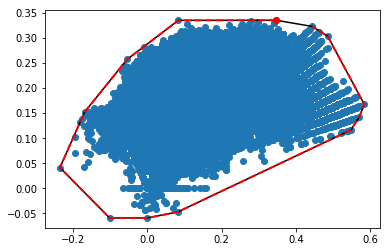

In [67]:
img = vis.copy()
border = 10
img[0:border,:,:] = 0
img[-border:,:,:] = 0
img[:,0:border,:] = 0
img[:,-border:,:] = 0
polar = np.reshape(img[:, :, [0,1]], (vis.shape[0]*vis.shape[1], 2))
theta = polar[:, 0] * 255 * 2 / 360 * 2 * np.pi # original range is {0-179}/255 we convert this into 0-2pi
from scipy.spatial import ConvexHull
r = polar[:, 1]
points = np.zeros(polar.shape)
points[:, 0] = r * np.cos(theta)
points[:, 1] = r * np.sin(theta)
hull = ConvexHull(points)
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()

We see that there are no strong endmembers (the painting is really faded). We can speak about endmember just in the area of red (angle from 0 up to 60 degrees). Which in other words means that we are able to estimate best the **red** areas (this is also supported by the highest correlation of hue with **HgL** channel)

### 3. Estimation of the RED
Evaluation of predictable RED areas we have made by *dropout* applied to our ANN. The principle is that other than HgL channels will be zeroed. We should see, that hue will be kept in red ares the most.

See image below:

Selecting 25000 samples randomly for use by algorithm.
Adding input layer, width = 10
Adding dense layer, width = 25
Adding dense layer, width = 25
Adding dense layer, width = 1
Compiling model took 0.1549's.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 74us/sample - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 2/10
20000/20000 [==============================] - 1s 57us/sample - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 3/10
20000/20000 [==============================] - 1s 54us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 4/10
20000/20000 [==============================] - 1s 53us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/10
20000/20000 [==============================] - 1s 56us/

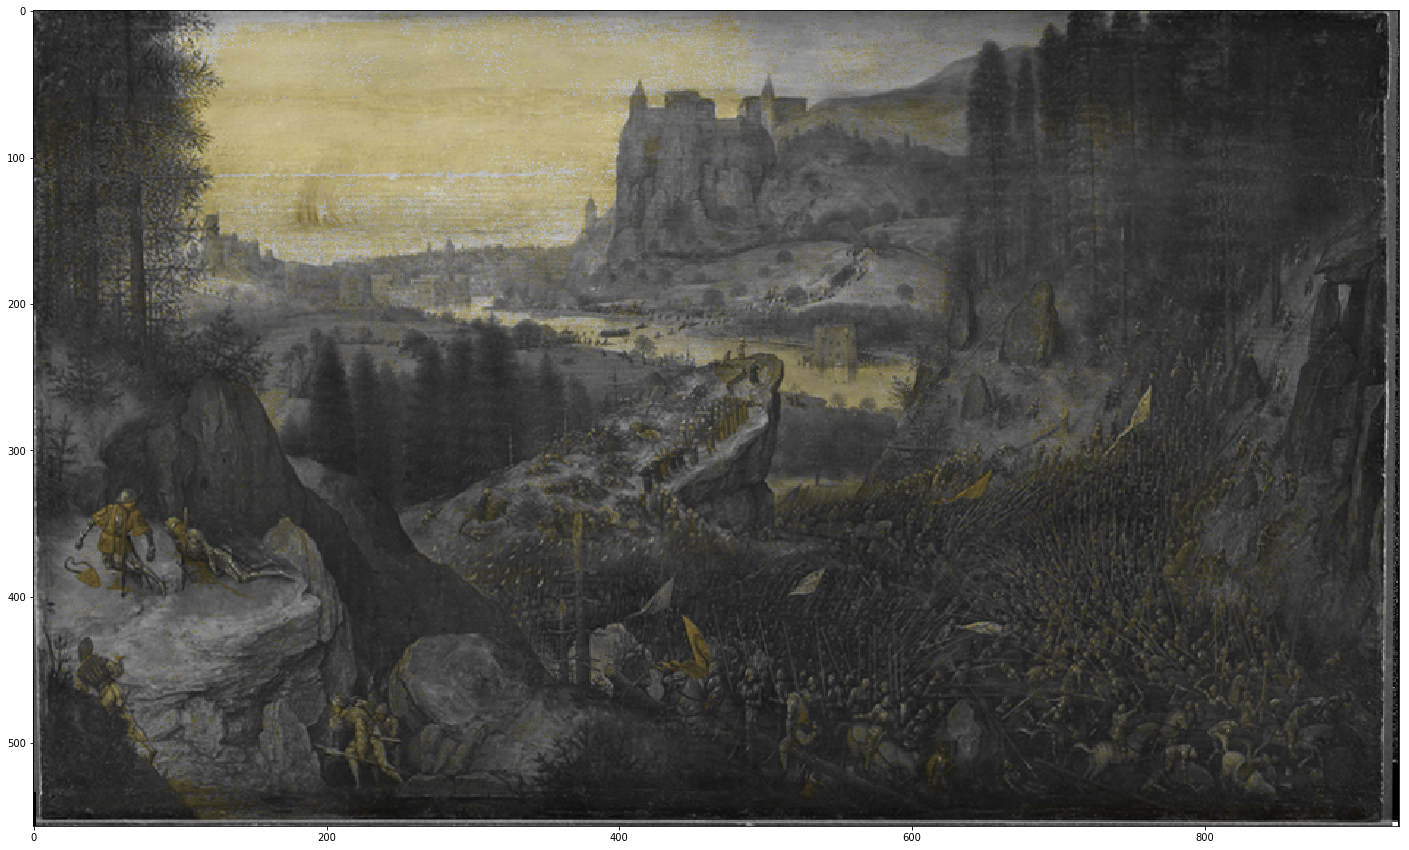

In [70]:
ins = saul[0][:,:,[1,4,6,7,9,10,11,14,18,19]]
ins[ins<0.8] = 0
_, _, dropout_model = ig.information_gain(ins, vis[:,:,0])
out = vis.copy()
modality = [11]
src = np.zeros(ins.shape)
for idx, value in enumerate(modality):
    src[:,:, idx] = saul[0][:,:,value]
out[:,:,0] = np.reshape(
    dropout_model.predict(np.reshape(src, (src.shape[0] * src.shape[1], src.shape[2]))), 
    (saul[0].shape[0], saul[0].shape[1], 1))[:,:,0]

out[np.sum(src, axis=2)==0,1] = 0

# And show the result
plt.figure(figsize=(30,15))
plt.imshow(cv2.cvtColor((out*255.0).astype(np.uint8), cv2.COLOR_HSV2RGB))

# Conclusion
We have made analysis of relation of XRF modalities and HUE of a real painting. Our analysis uncover very weak relation of these spectral bands to painting color at dataset *Suicide of Saul*.
For further analysis we recommend usage of painting with bright colors, where our findings can be disapproved and description of relations can be obtained.